# Seed sentence level blacklist with paragraph one split.

## Spacy (slow)

In [3]:
import json
from collections import Counter, defaultdict
import spacy
from tqdm.auto import tqdm

# -------- Step 0. Load and Split Paragraph Blacklist into Sentences --------
blacklist_file = "boilerplate_blacklist.jsonl"

# Load spaCy (English, lightweight)
nlp = spacy.load("en_core_web_sm", disable=["ner", "tagger", "parser"])
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")

# Function to tokenize text into sentences
def split_into_sentences(text):
    return [sent.text.strip() for sent in nlp(text).sents if sent.text.strip()]

# Load paragraph blacklist and split into sentences
seed_sentences = set()
with open(blacklist_file, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        parasentences = split_into_sentences(entry["text"])
        seed_sentences.update(parasentences)

print(f"Seed sentence blacklist size: {len(seed_sentences)}")

Seed sentence blacklist size: 13268


## Regex

In [11]:
import json
from tqdm.auto import tqdm
import re

# -------- Configuration --------
blacklist_file = "boilerplate_blacklist.jsonl"
output_file = "sentence_blacklist.jsonl"
MIN_SENT_LEN = 20  # filter very short sentences

# List of abbreviations not to split
ABBREVIATIONS = ["e.g.", "i.e.", "etc.", "vs.", "No.", "Fig.", "Eq.", "Ref."]
DECIMAL_REGEX = re.compile(r"\d+\.\d+")

# -------- Sentence splitting function --------
def split_into_sentences(text):
    # Protect decimals
    decimals = {}
    def decimal_replacer(match):
        key = f"__DECIMAL_{len(decimals)}__"
        decimals[key] = match.group(0)
        return key
    text = DECIMAL_REGEX.sub(decimal_replacer, text)

    # Protect abbreviations
    for abbr in ABBREVIATIONS:
        text = text.replace(abbr, abbr.replace(".", "__DOT__"))

    # Split on periods
    sentences = [s.strip() for s in text.split(".") if s.strip()]

    # Restore abbreviations and decimals
    restored = []
    for s in sentences:
        for key, val in decimals.items():
            s = s.replace(key, val)
        s = s.replace("__DOT__", ".")
        restored.append(s)
    return restored

# -------- Load paragraph blacklist and split into sentences --------
seed_sentences = set()
with open(blacklist_file, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        parasentences = split_into_sentences(entry["text"])
        seed_sentences.update(parasentences)

# Filter out very short sentences
seed_sentences = {s for s in seed_sentences if len(s) >= MIN_SENT_LEN}

print(f"Seed sentence blacklist size (after filtering short sentences): {len(seed_sentences)}")

# -------- Save to JSONL --------
with open(output_file, "w", encoding="utf-8") as fout:
    for s in tqdm(seed_sentences, desc="Saving sentence blacklist"):
        fout.write(json.dumps({
            "text": s,
            "total_count": 0, # As seed from paragraphs which have been filtered.
            "doc_count": 0
        }, ensure_ascii=False) + "\n")


Seed sentence blacklist size (after filtering short sentences): 13050


Saving sentence blacklist:   0%|          | 0/13050 [00:00<?, ?it/s]

# Remove seed sentence blacklist

Cleaning corpus: 0it [00:00, ?it/s]

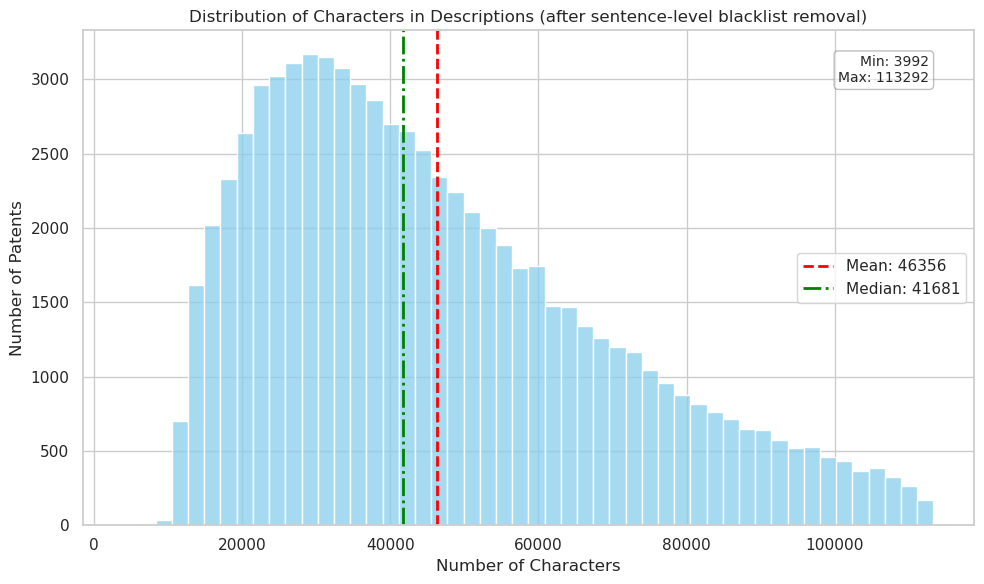

In [12]:
import json
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# -------- Load sentence blacklist --------
sentence_blacklist_file = "sentence_blacklist.jsonl"
blacklist_sentences = set()
with open(sentence_blacklist_file, "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        blacklist_sentences.add(entry["text"])

# -------- Sentence splitter (same as used before) --------
ABBREVIATIONS = ["e.g.", "i.e.", "etc.", "vs.", "No.", "Fig.", "Eq.", "Ref."]
import re
DECIMAL_REGEX = re.compile(r"\d+\.\d+")

def split_into_sentences(text):
    decimals = {}
    def decimal_replacer(match):
        key = f"__DECIMAL_{len(decimals)}__"
        decimals[key] = match.group(0)
        return key
    text = DECIMAL_REGEX.sub(decimal_replacer, text)
    for abbr in ABBREVIATIONS:
        text = text.replace(abbr, abbr.replace(".", "__DOT__"))
    sentences = [s.strip() for s in text.split(".") if s.strip()]
    restored = []
    for s in sentences:
        for key, val in decimals.items():
            s = s.replace(key, val)
        s = s.replace("__DOT__", ".")
        restored.append(s)
    return restored

# -------- Clean corpus --------
input_file = "coarse_cleaned_patents_filtered_dedup_para_bp.jsonl"
output_file = "coarse_cleaned_patents_filtered_dedup_para_bp_sent.jsonl"

cleaned_lengths = []

with open(input_file, "r", encoding="utf-8") as fin, open(output_file, "w", encoding="utf-8") as fout:
    for line in tqdm(fin, desc="Cleaning corpus"):
        doc = json.loads(line)
        paragraphs = [p for p in doc["description"].split("\n\n") if p.strip()]
        cleaned_paras = []
        for para in paragraphs:
            sentences = split_into_sentences(para)
            cleaned_sents = [s for s in sentences if s not in blacklist_sentences and len(s) >= 10]
            if cleaned_sents:
                cleaned_paras.append(". ".join(cleaned_sents) + ".")  # restore periods and paragraph
        cleaned_text = "\n\n".join(cleaned_paras)
        cleaned_lengths.append(len(cleaned_text))
        fout.write(json.dumps({
            "description": cleaned_text,
            "claim1": doc["claim1"]  # keep claims as-is
        }, ensure_ascii=False) + "\n")

# -------- Plot histogram --------
avg_len = np.mean(cleaned_lengths)
median_len = np.median(cleaned_lengths)
max_len = max(cleaned_lengths)
min_len = min(cleaned_lengths)

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.histplot(cleaned_lengths, bins=50, kde=False, color="skyblue")

plt.axvline(avg_len, color="red", linestyle="--", linewidth=2, label=f"Mean: {avg_len:.0f}")
plt.axvline(median_len, color="green", linestyle="-.", linewidth=2, label=f"Median: {median_len:.0f}")

plt.title("Distribution of Characters in Descriptions (after sentence-level blacklist removal)")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Patents")
plt.legend()
plt.text(0.95, 0.95, f"Min: {min_len}\nMax: {max_len}", transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.5))
plt.tight_layout()
plt.show()


In [14]:
from datasets import load_dataset

# Load the JSONL file
dataset = load_dataset("json", data_files="coarse_cleaned_patents_filtered_dedup_para_bp_sent.jsonl")

dataset = dataset["train"]

# Push to Hugging Face Hub
dataset.push_to_hub("mhurhangee/ep-patents-coarse-cleaned",commit_message="splitting paragraph blacklist into sentences and removing them")

Uploading the dataset shards:   0%|          | 0/8 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  279kB /  157MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  733kB /  154MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  358kB /  157MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  534kB /  157MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  611kB /  154MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  421kB /  154MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  630kB /  156MB            

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   0%|          |  586kB /  156MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/mhurhangee/ep-patents-coarse-cleaned/commit/4ab4dbc8128d4924f32233a829fefe585dc6d61e', commit_message='splitting paragraph blacklist into sentences and removing them', commit_description='', oid='4ab4dbc8128d4924f32233a829fefe585dc6d61e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mhurhangee/ep-patents-coarse-cleaned', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mhurhangee/ep-patents-coarse-cleaned'), pr_revision=None, pr_num=None)